# Time series prediction with LSTM (student notebook)

Neural networks like Long Short-Term Memory (LSTM) recurrent neural networks are able to almost seamlessly model problems with multiple input variables.

This is a great benefit in time series forecasting, where classical linear methods can be difficult to adapt to multivariate or multiple input forecasting problems.

In this lab, you will discover how you can develop an LSTM model for multivariate time series forecasting with the Keras deep learning library.

In [44]:
"""
(Practical tip) Table of contents can be compiled directly in jupyter notebooks using the following code:
I set an exception: if the package is in your installation you can import it otherwise you download it 
then import it.
"""
try:
    from jyquickhelper import add_notebook_menu 
except:
    !pip install jyquickhelper
    from jyquickhelper import add_notebook_menu
    
"""
Output Table of contents to navigate easily in the notebook. 
For interested readers, the package also includes Ipython magic commands to go back to this cell
wherever you are in the notebook to look for cells faster
"""
add_notebook_menu()

## Imports

In [45]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [46]:
import matplotlib.pyplot as plt

import math
import numpy as np 
import pandas as pd

In [47]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error

In [48]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, LSTM, Bidirectional, AveragePooling1D, RepeatVector
from tensorflow.keras import utils

## LSTM network for uni-variate time series

LSTM can be used to model univariate time series forecasting problems.

These problems consist of a single set of observations and a model is needed to learn from the past set of observations in order to forecast the next value in the sequence.

We will demonstrate a number of variations of the LSTM model for univariate time series forecasting.

Be careful not to draw hasty conclusions about the relative performance of the models. The number of layers or neurons are highly variable between models.

### Data preparation

#### A first example

Consider a given univariate sequence: `[10, 20, 30, 40, 50, 60, 70, 80, 90]`

We can divide the sequence into multiple input/output patterns called samples, where three time steps are used as input and one time step is used as output for the one-step prediction that is being learned.

`X,				y
10, 20, 30		40
20, 30, 40		50
30, 40, 50		60
...`

The `series_to_supervised()` function below implements this behavior and will split a given univariate sequence into multiple samples where each sample has a specified number of time steps (`n_in, by default 3`) and the output has also a specified number of time steps (`n_out, by default 1`).

By default, the data to predict is the last columns.

In [49]:
def series_to_supervised(data, n_in=3, n_out=1, output=None, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    output =  [data.columns[-1]] if output is None else output
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols += [df.shift(i)]
        names += [('%s(t-%d)' % (j, i)) for j in data.columns]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols += [df[output].shift(-i)]
        if i == 0:
            names += [('%s(t)' % (j)) for j in output]
        else:
            names += [('%s(t+%d)' % (j, i)) for j in output]
    
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

<font color='red'>
$TO DO - Students$

* create the time series mentioned in the first exemple.
</font>

In [50]:
d = {'numbers': [10, 20, 30, 40, 50, 60, 70, 80, 90]}
df = pd.DataFrame(data=d)
my_time_series = df

In [51]:
data = series_to_supervised(my_time_series, n_in=3, n_out= 1)
data.head()

,numbers(t-3),numbers(t-2),numbers(t-1),numbers(t)
3,10.0,20.0,30.0,40
4,20.0,30.0,40.0,50
5,30.0,40.0,50.0,60
6,40.0,50.0,60.0,70
7,50.0,60.0,70.0,80


<font color='blue'>
    <bold>Head of the previous dataset</bold>

`	0(t-3)	0(t-2)	0(t-1)	0(t)
3	0.0	10.0	20.0	30
4	10.0	20.0	30.0	40
5	20.0	30.0	40.0	50
6	30.0	40.0	50.0	60
7	40.0	50.0	60.0	70
`
</font>

#### Do the same for a more sophisticated series

In [52]:
SIZE = 250
time_stamps = range(SIZE)

fct = lambda x: x*math.sin(x)
time_series = pd.DataFrame(data={"data":[fct(x) for x in range(SIZE)]})
n_features = time_series.shape[1] # for univariate time series
time_series.shape

(250, 1)

<font color='red'>
$TO DO - Students$

* Plot the time series generated thanks to x --> x*sin(x) with 250 timestamps
* label x and y axis
</font>

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


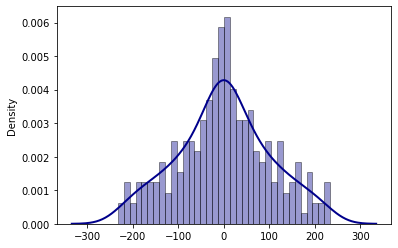

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.distplot(time_series, hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})

<font color='red'>
$TO DO - Students$

* Using `series_to_supervise` split data into samples with n_in = 6 and n_out = 1
* Put the result in variable data
</font>

In [54]:
""" FILL """
n_in=6
n_out= 1
data = series_to_supervised(time_series, n_in=6, n_out= 1)
data.head()

,data(t-6),data(t-5),data(t-4),data(t-3),data(t-2),data(t-1),data(t)
6,0.000000,0.841471,1.818595,0.423360,-3.027210,-4.794621,-1.676493
7,0.841471,1.818595,0.423360,-3.027210,-4.794621,-1.676493,4.598906
8,1.818595,0.423360,-3.027210,-4.794621,-1.676493,4.598906,7.914866
9,0.423360,-3.027210,-4.794621,-1.676493,4.598906,7.914866,3.709066
10,-3.027210,-4.794621,-1.676493,4.598906,7.914866,3.709066,-5.440211


<font color='blue'>
    <bold>Head of the previous dataset</bold>

`data(t-6)	data(t-5)	data(t-4)	data(t-3)	data(t-2)	data(t-1)	data(t)
6	0.000000	0.841471	1.818595	0.423360	-3.027210	-4.794621	-1.676493
7	0.841471	1.818595	0.423360	-3.027210	-4.794621	-1.676493	4.598906
8	1.818595	0.423360	-3.027210	-4.794621	-1.676493	4.598906	7.914866
9	0.423360	-3.027210	-4.794621	-1.676493	4.598906	7.914866	3.709066
10	-3.027210	-4.794621	-1.676493	4.598906	7.914866	3.709066	-5.440211
`
</font>

Contrary to the approaches used so far, we cannot separate the data into TRAIN, VALID and TEST in a random way, since we are dealing with time series where the order is important.

The TRAIN data will therefore necessarily be at the beginning, then we will find the VALIDATION data and finally the TEST data.

Here are the chosen indices.

In [55]:
testAndValid = 0.1

SPLIT = int(testAndValid*len(data))
idx_train = len(data)-2*SPLIT
idx_test = len(data)-SPLIT

print("TRAIN=time_series[:"+str(idx_train)+"]")
print("VALID=time_series["+str(idx_train)+":"+str(idx_test)+"]")
print("TEST=time_series["+str(idx_test)+":]")

TRAIN=data[:idx_train]
VAL=data[idx_train:idx_test]
TEST=data[idx_test:]

TRAIN=time_series[:196]
VALID=time_series[196:220]
TEST=time_series[220:]


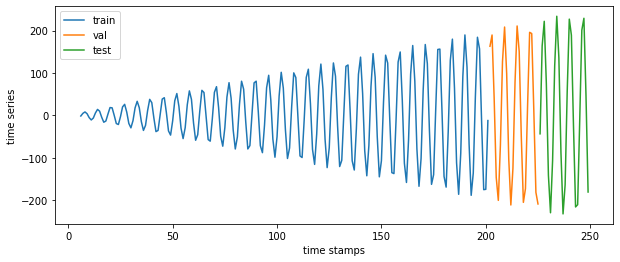

In [56]:
plt.figure(figsize=(10, 4))
plt.plot(TRAIN['data(t)'], label="train")
plt.plot(VAL['data(t)'], label="val")
plt.plot(TEST['data(t)'], label="test")
plt.legend()
plt.xlabel("time stamps");
plt.ylabel("time series");

<font color='red'>
$TO DO - Students$

* complete the code for preprocessing your train/validation/test datasets.
</font>

In [57]:
# split into input and outputs
train_X, train_y = TRAIN.values[:, :-n_out], TRAIN.values[:, -n_out]
val_X, val_y = VAL.values[:, :-n_out], VAL.values[:, -n_out]
test_X, test_y = TEST.values[:, :-n_out], TEST.values[:, -n_out]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((-1, n_in, n_features))
val_X = val_X.reshape((-1, n_in, n_features))
test_X = test_X.reshape((-1, n_in, n_features))

train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape

((196, 6, 1), (196,), (24, 6, 1), (24,), (24, 6, 1), (24,))

<font color='blue'>
<bold>
train_X.shape = (196, 6, 1)

train_y.shape = (196,)
</font>

### Build a first network using LSTM cells
<br>
<font color='red'>
$TO DO - Students$

* Look carefully at the following cell
* What is the impact of the `return_sequences` parameter of the LSTM cell? (change the value: False or True and observe the shape of the output).
</font>

return_sequences: True or False
- If False return only the last output
- If True return the full sequence of the output sequence

In [58]:
LSTM_SIZE = 16

inputs = Input(shape=(n_in, n_features))
hidden = LSTM(LSTM_SIZE, return_sequences=False, activation='relu')(inputs)
outputs = Dense(n_out, activation='linear')(hidden)
model = Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 6, 1)]            0         
                                                                 
 lstm_6 (LSTM)               (None, 16)                1152      
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,169
Trainable params: 1,169
Non-trainable params: 0
_________________________________________________________________


<font color='red'>
$TO DO - Students$

* Complete the function build_and_fit used to train your RNN model.
* compile : as usual
* fit : as usual but...
    * Be careful, you have to set the shuffle parameter to false in order to take the data in order.
    * Use the validation set to control the overfitting in the earlystopping callback
</font>

In [59]:
def build_and_fit(model, X_train, y_train, X_val, y_val, X_test, y_test):

    #Compile model
    model.compile(loss='mean_absolute_error', 
              optimizer='adam', 
              metrics=['mean_absolute_error'])
    
    #Define early-stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

    #Fit the model. shuffle=False
    history = model.fit(X_train, y_train,
                    epochs=200,
                    verbose=2,
                    callbacks=[es],
                    validation_data= [X_val, y_val],
                    shuffle=False) 
    
    #Predict the model
    y_pred = model.predict(X_test)
    
    # plot history
    plt.figure(figsize=(20,8))

    plt.subplot(331)
    plt.plot(history.history['loss'][3:], label='loss')
    plt.plot(history.history['val_loss'][3:], label='val_loss')
    plt.legend()
    
    plt.subplot(332)
    plt.plot(history.history['mean_absolute_error'][3:], label='mean_absolute_error')
    plt.plot(history.history['val_mean_absolute_error'][3:], label='val_mean_absolute_error')
    plt.legend()
    
    plt.subplot(333)
    plt.plot(range(len(y_train)), y_train, label="train")
    plt.plot(range(len(y_train), len(y_train)+len(y_val)), y_val, label="valid")
    plt.plot(range(len(y_train)+len(y_val), len(y_train)+len(y_val)+len(y_pred)), y_test, label="test")
    plt.plot(range(len(y_train)+len(y_val), len(y_train)+len(y_val)+len(y_pred)), y_pred, label="predict")

    plt.legend(loc='center left')
    plt.show()
    
    return model

Epoch 1/200
7/7 - 2s - loss: 63.9863 - mean_absolute_error: 63.9863 - val_loss: 135.0868 - val_mean_absolute_error: 135.0868 - 2s/epoch - 225ms/step
Epoch 2/200
7/7 - 0s - loss: 61.7180 - mean_absolute_error: 61.7180 - val_loss: 129.2415 - val_mean_absolute_error: 129.2415 - 44ms/epoch - 6ms/step
Epoch 3/200
7/7 - 0s - loss: 59.2255 - mean_absolute_error: 59.2255 - val_loss: 122.7255 - val_mean_absolute_error: 122.7255 - 45ms/epoch - 6ms/step
Epoch 4/200
7/7 - 0s - loss: 56.3184 - mean_absolute_error: 56.3184 - val_loss: 115.3704 - val_mean_absolute_error: 115.3704 - 44ms/epoch - 6ms/step
Epoch 5/200
7/7 - 0s - loss: 53.4180 - mean_absolute_error: 53.4180 - val_loss: 108.9836 - val_mean_absolute_error: 108.9836 - 44ms/epoch - 6ms/step
Epoch 6/200
7/7 - 0s - loss: 50.5333 - mean_absolute_error: 50.5333 - val_loss: 104.2041 - val_mean_absolute_error: 104.2041 - 50ms/epoch - 7ms/step
Epoch 7/200
7/7 - 0s - loss: 48.0460 - mean_absolute_error: 48.0460 - val_loss: 98.5749 - val_mean_absolut

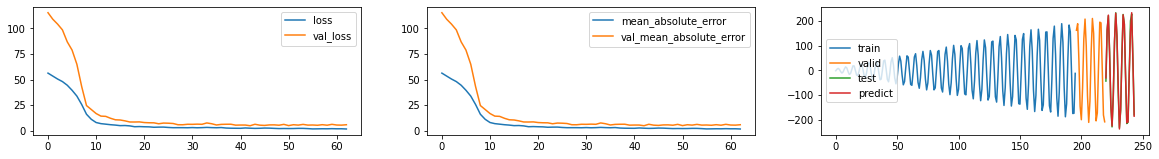

In [60]:
model = build_and_fit(model, train_X, train_y, val_X, val_y, test_X, test_y)

In [61]:
# demonstrate prediction
start = 12
y_true = (start+n_in)*(start+n_in)
x_input = np.array([fct(x) for x in range(start,start+n_in)])
x_input = x_input.reshape((1, n_in, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat, y_true)

[[-12.656905]] 324


### Stacked Bi-LSTM

In order to improve the performance of the model, it's possible to:
- stack LSTM with `return_sequence=True` for all levels except the last one where `return_sequence=False`
- use Bi-LSTM

<font color='red'>
$TO DO - Students$

* Build a model stacking 3 BI-LSTM layers 
</font>

To stack LSTM layers, we need to change the configuration of the prior LSTM layer to output a 3D array as input for the subsequent layer.

We can do this by setting the return_sequences argument on the layer to True (defaults to False). This will return one output for each input time step and provide a 3D array.

In [62]:
inputs = Input(shape=(n_in, n_features))
hidden1 = LSTM(LSTM_SIZE, return_sequences=True, activation='relu')(inputs)
hidden2 = LSTM(LSTM_SIZE, return_sequences=True, activation='relu')(hidden1)
hidden3 = LSTM(LSTM_SIZE, return_sequences=False, activation='relu')(hidden2)

outputs = Dense(n_out, activation='linear')(hidden3)
model = Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 6, 1)]            0         
                                                                 
 lstm_7 (LSTM)               (None, 6, 16)             1152      
                                                                 
 lstm_8 (LSTM)               (None, 6, 16)             2112      
                                                                 
 lstm_9 (LSTM)               (None, 16)                2112      
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 5,393
Trainable params: 5,393
Non-trainable params: 0
_________________________________________________________________


Epoch 1/200
7/7 - 4s - loss: 65.4916 - mean_absolute_error: 65.4916 - val_loss: 139.7300 - val_mean_absolute_error: 139.7300 - 4s/epoch - 560ms/step
Epoch 2/200
7/7 - 0s - loss: 65.3438 - mean_absolute_error: 65.3438 - val_loss: 139.4273 - val_mean_absolute_error: 139.4273 - 76ms/epoch - 11ms/step
Epoch 3/200
7/7 - 0s - loss: 65.1639 - mean_absolute_error: 65.1639 - val_loss: 138.9187 - val_mean_absolute_error: 138.9187 - 75ms/epoch - 11ms/step
Epoch 4/200
7/7 - 0s - loss: 64.8951 - mean_absolute_error: 64.8951 - val_loss: 138.0954 - val_mean_absolute_error: 138.0954 - 83ms/epoch - 12ms/step
Epoch 5/200
7/7 - 0s - loss: 64.4258 - mean_absolute_error: 64.4258 - val_loss: 136.6146 - val_mean_absolute_error: 136.6146 - 83ms/epoch - 12ms/step
Epoch 6/200
7/7 - 0s - loss: 63.3581 - mean_absolute_error: 63.3581 - val_loss: 132.2368 - val_mean_absolute_error: 132.2368 - 76ms/epoch - 11ms/step
Epoch 7/200
7/7 - 0s - loss: 60.6312 - mean_absolute_error: 60.6312 - val_loss: 122.4243 - val_mean_a

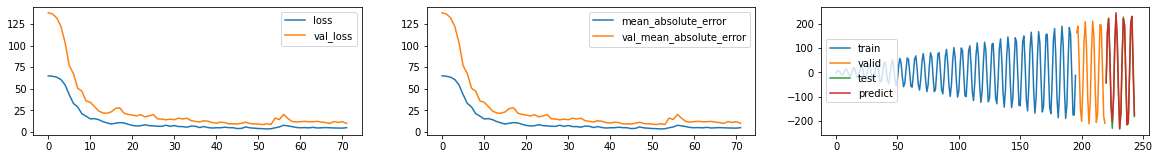

In [63]:
model = build_and_fit(model, train_X, train_y, val_X, val_y, test_X, test_y)

In [64]:
# demonstrate prediction
start = 12
y_true = (start+n_in)*(start+n_in)
x_input = np.array([fct(x) for x in range(start,start+n_in)])
x_input = x_input.reshape((1, n_in, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat, y_true)

[[-14.303253]] 324


## LSTM network for multi-variate time series 

Multivariate time series data means data where there is more than one observation for each time step.

There are two main models we may need with multivariate time series data. These are the multiple input series or the multiple parallel series depending on whether we want to predict one or more of the variables.

In this notebook, we focus on the first case: as input, several time series and as output (the prediction), a single time series.

### Prepare the data

We reuse the same `series_to_supervise()` function in order to build a dataset with :
* n_in elements for each series
* n_out elements for each series to be predict

You have also to select one (Multiple Input Series) or many time series (Multiple Parallel Series) to predict.

In [65]:
# Get the time series
fct2 = lambda x: 2*x
time_series1 = [fct(x) for x in range(SIZE)]
time_series2 = [fct2(x) for x in range(SIZE)]
out_seq = [time_series1[i]+time_series2[i] for i in range(SIZE)]

#See the shape:
len(out_seq)

250

In [66]:
# Get the dataset
dataset = pd.DataFrame(data={"f1":time_series1, "f2":time_series2, "output":out_seq}, index=range(SIZE))
n_features = dataset.shape[1] # for multivariate time series
print(dataset.shape)
dataset.head()

(250, 3)


,f1,f2,output
0,0.000000,0,0.000000
1,0.841471,2,2.841471
2,1.818595,4,5.818595
3,0.423360,6,6.423360
4,-3.027210,8,4.972790


As with the univariate time series, we must structure these data into samples with input and output elements.
An LSTM model needs sufficient context to learn a mapping from an input sequence to an output value. LSTMs can support parallel input time series as separate variables or features. Therefore, we need to split the data into samples maintaining the order of observations across the two input sequences.

If we chose six input time steps for the three features, we have to transform the dataset in the following way.

In [67]:
# As previously, prepare the dataset
''' In the followig example, we select 
- n_in number of time steps (6)
- n_out number of time steps of output
- and one serie to predict : output
'''
n_features = dataset.shape[1] # for multivariate time series
n_in = 6
n_out = 1
output = ["output"]

data = series_to_supervised(dataset, n_in, n_out, output=output)
data.head()

,f1(t-6),f2(t-6),output(t-6),f1(t-5),f2(t-5),output(t-5),f1(t-4),f2(t-4),output(t-4),f1(t-3),f2(t-3),output(t-3),f1(t-2),f2(t-2),output(t-2),f1(t-1),f2(t-1),output(t-1),output(t)
6,0.000000,0.0,0.000000,0.841471,2.0,2.841471,1.818595,4.0,5.818595,0.423360,6.0,6.423360,-3.027210,8.0,4.972790,-4.794621,10.0,5.205379,10.323507
7,0.841471,2.0,2.841471,1.818595,4.0,5.818595,0.423360,6.0,6.423360,-3.027210,8.0,4.972790,-4.794621,10.0,5.205379,-1.676493,12.0,10.323507,18.598906
8,1.818595,4.0,5.818595,0.423360,6.0,6.423360,-3.027210,8.0,4.972790,-4.794621,10.0,5.205379,-1.676493,12.0,10.323507,4.598906,14.0,18.598906,23.914866
9,0.423360,6.0,6.423360,-3.027210,8.0,4.972790,-4.794621,10.0,5.205379,-1.676493,12.0,10.323507,4.598906,14.0,18.598906,7.914866,16.0,23.914866,21.709066
10,-3.027210,8.0,4.972790,-4.794621,10.0,5.205379,-1.676493,12.0,10.323507,4.598906,14.0,18.598906,7.914866,16.0,23.914866,3.709066,18.0,21.709066,14.559789


In [68]:
# Split dataset into TRAIN, VAL and TEST
testAndValid = 0.1

SPLIT = int(testAndValid*len(data))
idx_train = len(data)-2*SPLIT
idx_test = len(data)-SPLIT

print("TRAIN=time_series[:"+str(idx_train)+"]")
print("VALID=time_series["+str(idx_train)+":"+str(idx_test)+"]")
print("TEST=time_series["+str(idx_test)+":]")

TRAIN=data[:idx_train]
VAL=data[idx_train:idx_test]
TEST=data[idx_test:]

TRAIN=time_series[:196]
VALID=time_series[196:220]
TEST=time_series[220:]


<font color='red'>
$TO DO - Students$

* build train_X, val_X, test_X and train_y, val_y and test_y as before. Then print the shapes of tensors
    * train_X is a 3D-tensor (196, 6, 3) for me
    * train_y is a 1D-tensor (196,)
</font>

In [69]:
""" FILL """

# split into input and outputs
train_X, train_y = TRAIN.values[:, :-n_out], TRAIN.values[:, -n_out]
val_X, val_y = VAL.values[:, :-n_out], VAL.values[:, -n_out]
test_X, test_y = TEST.values[:, :-n_out], TEST.values[:, -n_out]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((-1, n_in, n_features))
val_X = val_X.reshape((-1, n_in, n_features))
test_X = test_X.reshape((-1, n_in, n_features))

print("train_X.shape, train_y.shape ", train_X.shape, train_y.shape )
print("val_X.shape, val_y.shape",val_X.shape, val_y.shape)
print("test_X.shape, test_y.shape", test_X.shape, test_y.shape)

train_X.shape, train_y.shape  (196, 6, 3) (196,)
val_X.shape, val_y.shape (24, 6, 3) (24,)
test_X.shape, test_y.shape (24, 6, 3) (24,)


### Build a neuronal model

Any of the varieties of LSTMs in the previous section can be used, such as a Vanilla, Stacked, Bidirectional. It's also possible to use CNN or mixed CNN and LSTM.

We will use a Vanilla LSTM where the number of time steps and parallel series (features) are specified for the input layer via the input_shape argument.

In [70]:
inputs = Input(shape=(n_in, n_features))
hidden = LSTM(LSTM_SIZE, return_sequences=False, activation='relu')(inputs)
outputs = Dense(n_out, activation='linear')(hidden)
model = Model(inputs, outputs)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 6, 3)]            0         
                                                                 
 lstm_10 (LSTM)              (None, 16)                1280      
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,297
Trainable params: 1,297
Non-trainable params: 0
_________________________________________________________________


Epoch 1/200
7/7 - 2s - loss: 204.7721 - mean_absolute_error: 204.7721 - val_loss: 424.3469 - val_mean_absolute_error: 424.3469 - 2s/epoch - 228ms/step
Epoch 2/200
7/7 - 0s - loss: 204.0296 - mean_absolute_error: 204.0296 - val_loss: 423.0189 - val_mean_absolute_error: 423.0189 - 45ms/epoch - 6ms/step
Epoch 3/200
7/7 - 0s - loss: 203.2113 - mean_absolute_error: 203.2113 - val_loss: 421.6277 - val_mean_absolute_error: 421.6277 - 43ms/epoch - 6ms/step
Epoch 4/200
7/7 - 0s - loss: 202.2569 - mean_absolute_error: 202.2569 - val_loss: 419.2127 - val_mean_absolute_error: 419.2127 - 44ms/epoch - 6ms/step
Epoch 5/200
7/7 - 0s - loss: 201.0128 - mean_absolute_error: 201.0128 - val_loss: 415.8944 - val_mean_absolute_error: 415.8944 - 48ms/epoch - 7ms/step
Epoch 6/200
7/7 - 0s - loss: 199.2789 - mean_absolute_error: 199.2789 - val_loss: 412.4673 - val_mean_absolute_error: 412.4673 - 49ms/epoch - 7ms/step
Epoch 7/200
7/7 - 0s - loss: 196.3936 - mean_absolute_error: 196.3936 - val_loss: 403.8230 - v

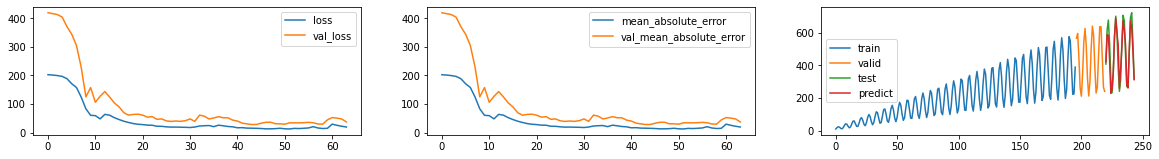

In [71]:
model = build_and_fit(model, train_X, train_y, val_X, val_y, test_X, test_y)

## Lab work: Air Pollution Forecasting

This is a dataset that reports on the weather and the level of pollution each hour for five years at the US embassy in Beijing, China.

The data includes the date-time, the pollution called PM2.5 concentration, and the weather information including dew point, temperature, pressure, wind direction, wind speed and the cumulative number of hours of snow and rain. The complete feature list in the raw data is as follows:

1. No: row number
1. year: year of data in this row
1. month: month of data in this row
1. day: day of data in this row
1. hour: hour of data in this row
1. pm2.5: PM2.5 concentration
1. DEWP: Dew Point
1. TEMP: Temperature
1. PRES: Pressure
1. cbwd: Combined wind direction
1. Iws: Cumulated wind speed
1. Is: Cumulated hours of snow
1. Ir: Cumulated hours of rain

We can use this data and frame a forecasting problem where, given the weather conditions and pollution for prior hours, we forecast the pollution at the next hour.

This dataset can be used to frame other forecasting problems.

## Load the data

In [72]:
DATAPATH = "https://www.i3s.unice.fr/~riveill/dataset/pollution.csv"

In [73]:
# Read the dataset
data = pd.read_csv(DATAPATH, sep=",", header=0, index_col=0)
print(data.shape)
data.head()

(43800, 8)


,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


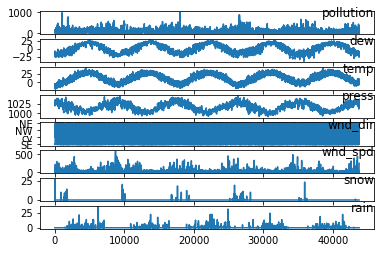

In [74]:
plt.figure()
for i, column in enumerate(data.columns):
    plt.subplot(len(data.columns), 1, i+1)
    plt.plot(data[column].to_numpy())
    plt.title(column, y=0.5, loc='right')
plt.show()

### Construct the dataset

The first step is to prepare the pollution dataset for the LSTM.

This involves framing the dataset as a supervised learning problem and normalizing the input variables.

We will frame the supervised learning problem as predicting the pollution at the current hour (t) given the pollution measurement and weather conditions at the prior time step.

In [75]:
n_features = data.shape[1] # for multivariate time series
n_in = 6
n_out = 1
output = ["pollution"]

n_features


8

<font color='red'>
$TO DO - Students$

* using `series_to_supervised` function build the dataset
</font>

In [76]:
dataset = series_to_supervised(data, n_in=6, n_out= 1, output=output)
dataset.head(3)

,pollution(t-6),dew(t-6),temp(t-6),press(t-6),wnd_dir(t-6),wnd_spd(t-6),snow(t-6),rain(t-6),pollution(t-5),dew(t-5),temp(t-5),press(t-5),wnd_dir(t-5),wnd_spd(t-5),snow(t-5),rain(t-5),pollution(t-4),dew(t-4),temp(t-4),press(t-4),wnd_dir(t-4),wnd_spd(t-4),snow(t-4),rain(t-4),pollution(t-3),dew(t-3),temp(t-3),press(t-3),wnd_dir(t-3),wnd_spd(t-3),snow(t-3),rain(t-3),pollution(t-2),dew(t-2),temp(t-2),press(t-2),wnd_dir(t-2),wnd_spd(t-2),snow(t-2),rain(t-2),pollution(t-1),dew(t-1),temp(t-1),press(t-1),wnd_dir(t-1),wnd_spd(t-1),snow(t-1),rain(t-1),pollution(t)
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-01-02 06:00:00,129.0,-16.0,-4.0,1020.0,SE,1.79,0.0,0.0,148.0,-15.0,-4.0,1020.0,SE,2.68,0.0,0.0,159.0,-11.0,-5.0,1021.0,SE,3.57,0.0,0.0,181.0,-7.0,-5.0,1022.0,SE,5.36,1.0,0.0,138.0,-7.0,-5.0,1022.0,SE,6.25,2.0,0.0,109.0,-7.0,-6.0,1022.0,SE,7.14,3.0,0.0,105.0
2010-01-02 07:00:00,148.0,-15.0,-4.0,1020.0,SE,2.68,0.0,0.0,159.0,-11.0,-5.0,1021.0,SE,3.57,0.0,0.0,181.0,-7.0,-5.0,1022.0,SE,5.36,1.0,0.0,138.0,-7.0,-5.0,1022.0,SE,6.25,2.0,0.0,109.0,-7.0,-6.0,1022.0,SE,7.14,3.0,0.0,105.0,-7.0,-6.0,1023.0,SE,8.93,4.0,0.0,124.0
2010-01-02 08:00:00,159.0,-11.0,-5.0,1021.0,SE,3.57,0.0,0.0,181.0,-7.0,-5.0,1022.0,SE,5.36,1.0,0.0,138.0,-7.0,-5.0,1022.0,SE,6.25,2.0,0.0,109.0,-7.0,-6.0,1022.0,SE,7.14,3.0,0.0,105.0,-7.0,-6.0,1023.0,SE,8.93,4.0,0.0,124.0,-7.0,-5.0,1024.0,SE,10.72,0.0,0.0,120.0


In [77]:
dataset.dtypes

pollution(t-6)    float64
dew(t-6)          float64
temp(t-6)         float64
press(t-6)        float64
wnd_dir(t-6)       object
wnd_spd(t-6)      float64
snow(t-6)         float64
rain(t-6)         float64
pollution(t-5)    float64
dew(t-5)          float64
temp(t-5)         float64
press(t-5)        float64
wnd_dir(t-5)       object
wnd_spd(t-5)      float64
snow(t-5)         float64
rain(t-5)         float64
pollution(t-4)    float64
dew(t-4)          float64
temp(t-4)         float64
press(t-4)        float64
wnd_dir(t-4)       object
wnd_spd(t-4)      float64
snow(t-4)         float64
rain(t-4)         float64
pollution(t-3)    float64
dew(t-3)          float64
temp(t-3)         float64
press(t-3)        float64
wnd_dir(t-3)       object
wnd_spd(t-3)      float64
snow(t-3)         float64
rain(t-3)         float64
pollution(t-2)    float64
dew(t-2)          float64
temp(t-2)         float64
press(t-2)        float64
wnd_dir(t-2)       object
wnd_spd(t-2)      float64
snow(t-2)   

<font color='blue'>
<bold>dataset.dtypes gives the following result for me</bold>

<pre>
pollution(t-6)    float64
dew(t-6)          float64
temp(t-6)         float64
press(t-6)        float64
wnd_dir(t-6)       object
wnd_spd(t-6)      float64
snow(t-6)         float64
rain(t-6)         float64
pollution(t-5)    float64
dew(t-5)          float64
temp(t-5)         float64
press(t-5)        float64
wnd_dir(t-5)       object
wnd_spd(t-5)      float64
snow(t-5)         float64
rain(t-5)         float64
pollution(t-4)    float64
dew(t-4)          float64
temp(t-4)         float64
press(t-4)        float64
wnd_dir(t-4)       object
wnd_spd(t-4)      float64
snow(t-4)         float64
rain(t-4)         float64
pollution(t-3)    float64
dew(t-3)          float64
temp(t-3)         float64
press(t-3)        float64
wnd_dir(t-3)       object
wnd_spd(t-3)      float64
snow(t-3)         float64
rain(t-3)         float64
pollution(t-2)    float64
dew(t-2)          float64
temp(t-2)         float64
press(t-2)        float64
wnd_dir(t-2)       object
wnd_spd(t-2)      float64
snow(t-2)         float64
rain(t-2)         float64
pollution(t-1)    float64
dew(t-1)          float64
temp(t-1)         float64
press(t-1)        float64
wnd_dir(t-1)       object
wnd_spd(t-1)      float64
snow(t-1)         float64
rain(t-1)         float64
pollution(t)      float64
dtype: object
<pre>
</font>

First, we must split the prepared dataset into train and test sets. To speed up the training of the model for this demonstration, we will only fit the model on the first year of data, then evaluate it on the remaining 4 years of data. 

The example below splits the dataset into train and test sets, then splits the train and test sets into input and output variables. Finally, the inputs (X) are reshaped into the 3D format expected by LSTMs, namely [samples, timesteps, features].

In [78]:
# get the values
values = dataset.values

# split into train and test sets
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
val = values[n_train_hours:2*n_train_hours, :]
test = values[2*n_train_hours:, :]

# split into input and outputs
train_X, train_y = train[:, :-n_out], np.array(train[:, -n_out], dtype="float64")
val_X, val_y = val[:, :-n_out], np.array(val[:, -n_out], dtype="float64")
test_X, test_y = test[:, :-n_out], np.array(test[:, -n_out], dtype="float64")

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_in, n_features))
val_X = val_X.reshape((val_X.shape[0], n_in, n_features))
test_X = test_X.reshape((test_X.shape[0], n_in, n_features))
train_X.shape, train_y.shape

((8760, 6, 8), (8760,))

### Encode and normalize dataset

Data encoding and normalization
* The wind direction feature is label encoded (integer encoded).
* All features are normalized

And then the dataset is transformed into a supervised learning problem. The weather variables for the hour to be predicted (t) are then removed.

In [79]:
numeric_features = [i for i, t in enumerate(dataset.dtypes[:-n_out]) if t in ['float64', 'int32']]
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = [i for i in range(len(dataset.columns)-n_out) if i not in numeric_features]
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

train_X_enc = preprocessor.fit_transform(train_X.reshape(len(train_X), -1)).reshape(len(train_X), n_in, -1)
val_X_enc = preprocessor.fit_transform(val_X.reshape(len(val_X), -1)).reshape(len(val_X), n_in, -1)
test_X_enc = preprocessor.transform(test_X.reshape(len(test_X), -1)).reshape(len(test_X), n_in, -1)
                                                                                    
n_features = train_X_enc.shape[2] # Change with oneHotEncode
n_features

11

Running the code below prepare the data. Executing the next cell, prints the first 5 rows of the transformed dataset. We can see the 8 input variables (input series) and the 1 output variable (pollution level at the current hour).

### Build, Compile, Fit, Predict and Evaluate a model
<br>
<font color='red'>
$TO DO - Students$

* Build your model
    * Put the number of hidden layers you want. If possible more than one.
</font>

In [80]:


LSTM_SIZE = 15

inputs = Input(shape=(n_in, n_features))
hidden1 = LSTM(LSTM_SIZE, return_sequences=True, activation='relu')(inputs)
hidden2 = LSTM(LSTM_SIZE, return_sequences=True, activation='relu')(hidden1)
hidden3 = LSTM(LSTM_SIZE, return_sequences=False, activation='relu')(hidden2)
outputs = Dense(n_out, activation='linear')(hidden3)
model = Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 6, 11)]           0         
                                                                 
 lstm_11 (LSTM)              (None, 6, 15)             1620      
                                                                 
 lstm_12 (LSTM)              (None, 6, 15)             1860      
                                                                 
 lstm_13 (LSTM)              (None, 15)                1860      
                                                                 
 dense_5 (Dense)             (None, 1)                 16        
                                                                 
Total params: 5,356
Trainable params: 5,356
Non-trainable params: 0
_________________________________________________________________


<font color='red'>
$TO DO - Students$

* Compile your model
</font>

In [81]:
# Compile the model
model.compile(loss='mean_absolute_error', 
              optimizer='adam', 
              metrics=['mean_absolute_error'])

<font color='red'>
$TO DO - Students$

* Fit your model using `EarlyStopping`
</font>

In [82]:

#Define early-stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

#Fit the model. shuffle=False
history = model.fit(train_X_enc, train_y, 
                    epochs=200, 
                    verbose=2, 
                    callbacks=[es], 
                    validation_data= [val_X_enc, val_y], 
                    shuffle=False) 

Epoch 1/200
274/274 - 7s - loss: 80.8383 - mean_absolute_error: 80.8383 - val_loss: 69.7681 - val_mean_absolute_error: 69.7681 - 7s/epoch - 25ms/step
Epoch 2/200
274/274 - 3s - loss: 57.7617 - mean_absolute_error: 57.7617 - val_loss: 44.2153 - val_mean_absolute_error: 44.2153 - 3s/epoch - 10ms/step
Epoch 3/200
274/274 - 3s - loss: 45.1966 - mean_absolute_error: 45.1966 - val_loss: 40.7351 - val_mean_absolute_error: 40.7351 - 3s/epoch - 10ms/step
Epoch 4/200
274/274 - 3s - loss: 41.2315 - mean_absolute_error: 41.2315 - val_loss: 38.4791 - val_mean_absolute_error: 38.4791 - 3s/epoch - 10ms/step
Epoch 5/200
274/274 - 3s - loss: 38.7559 - mean_absolute_error: 38.7559 - val_loss: 39.3901 - val_mean_absolute_error: 39.3901 - 3s/epoch - 10ms/step
Epoch 6/200
274/274 - 3s - loss: 36.7714 - mean_absolute_error: 36.7714 - val_loss: 38.2652 - val_mean_absolute_error: 38.2652 - 3s/epoch - 10ms/step
Epoch 7/200
274/274 - 3s - loss: 34.5762 - mean_absolute_error: 34.5762 - val_loss: 32.9436 - val_me

<font color='red'>
$TO DO - Students$

* Use your model to predict test set data
</font>

In [83]:

# make a prediction

pred = model.predict(test_X_enc)


<font color='red'>
$TO DO - Students$

* Plot learning curve
</font>

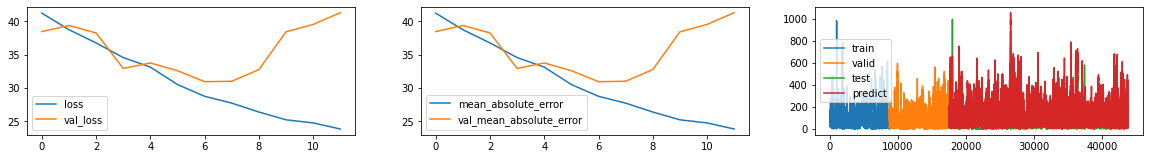

In [84]:
""" PLOT """

    
# plot history
plt.figure(figsize=(20,8))

plt.subplot(331)
plt.plot(history.history['loss'][3:], label='loss')
plt.plot(history.history['val_loss'][3:], label='val_loss')
plt.legend()

plt.subplot(332)
plt.plot(history.history['mean_absolute_error'][3:], label='mean_absolute_error')
plt.plot(history.history['val_mean_absolute_error'][3:], label='val_mean_absolute_error')
plt.legend()

plt.subplot(333)
plt.plot(range(len(train_y)), train_y, label="train")
plt.plot(range(len(train_y), len(train_y)+len(val_y)), val_y, label="valid")
plt.plot(range(len(train_y)+len(val_y), len(train_y)+len(val_y)+len(pred)), test_y, label="test")
plt.plot(range(len(train_y)+len(val_y), len(train_y)+len(val_y)+len(pred)), pred, label="predict")

plt.legend(loc='center left')
plt.show()

<font color='red'>
$TO DO - Students$

* Evaluate your model with RMSA
</font>

In [85]:

# calculate RMSE

from tensorflow.keras.metrics import RootMeanSquaredError as RMSE

rmse = RMSE(dtype='float64')
rmse_result = rmse(pred, test_y)

'Test RMSE: %.3f' % rmse_result

'Test RMSE: 57.166'

We got the RMSE value of test as 57.166.

### Predict next day

Generally, what we are trying to predict is a pollution indicator for the day or per 12-hour period. 

Modify the datasets to create a new column giving a pollution indicator per half day: little pollution, moderate pollution, heavy pollution.

Let's define the data path again and load the dataset to a data frame called 'df':

In [86]:
DATAPATH = "https://www.i3s.unice.fr/~riveill/dataset/pollution.csv"

In [87]:
import pandas as pd
#index_col=1
df = pd.read_csv(DATAPATH, sep=",", header=0, index_col=0)
print(df.shape)
df.head()

(43800, 8)


,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


Then, create two additional columns as 'hour' and 'day'. At the begining the hour column is 0 and day column is empty string. We will assign values to them very soon.

In [88]:
#Create a new column called 'hour'. At the begining assign every row to 0 in the new column.
df['hour']=0
df['day'] = ''
df.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain,hour,day
date,,,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0,0,
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0,0,
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0,0,
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0,0,
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0,0,


Let's fill the hour and day columns. For every row I take the index(date) and split it into day and hour. If the hour is less than or equal to 12, that means it is the first half of the day. If the hour is greater than 12, then it is afternoon. The first half of the day is indicated as 'morning', and the other half is indicated as 'afternoon'. 


For example if the date is 2010-01-02 04:00:00	then,
1. The hour is 04
2. So, the day is "2010-01-02-morning"



In [89]:
for i in range(len(df)):
  #morning
  if int(df.index[i][-8:-6]) <= 12:
    df['hour'][i] = df.index[i][-8:-6]
    df['day'][i] = df.index[i][0:10] + '-morning'
  #afternoon
  else:
    df['hour'][i] = df.index[i][-8:-6]
    df['day'][i] = df.index[i][0:10] + '-afternoon'

df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: Se

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain,hour,day
date,,,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0,0,2010-01-02-morning
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0,1,2010-01-02-morning
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0,2,2010-01-02-morning
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0,3,2010-01-02-morning
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0,4,2010-01-02-morning


Next, we can group by the data frame according to day and calculate the pollution mean: 

In [90]:
#Group by 'day' and create a new column as 'pollution_mean'
df['pollution_mean'] = df.groupby('day')['pollution'].transform('mean')
df.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain,hour,day,pollution_mean
date,,,,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0,0,2010-01-02-morning,137.307692
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0,1,2010-01-02-morning,137.307692
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0,2,2010-01-02-morning,137.307692
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0,3,2010-01-02-morning,137.307692
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0,4,2010-01-02-morning,137.307692


I found the pollution mean per half day. Now, we can create a new column as 'pollution_indicator' which defines how much pollution the half-day has. The categories for this new column is 
1. little pollution
2. moderate pollution
3. heavy pollution

To find whether the pollution is little, moderate or heavy, I found the max and min of pollution values and divide it 3 equal regoins. 

In [91]:
#Create a new column:
df['pollution_indicator'] = ''

#Max pollution
max_pol = df['pollution_mean'].max()
#Min pollution
min_pol = df['pollution_mean'].min()

#The borders of the pollution values:
limit1 = max_pol / 3.0
limit2 = max_pol * 2 / 3.0

print("The first region is: [", min_pol ,"-", limit1, "]")
print("The second region is: [", limit1 ,"-", limit2, "]")
print("The third region is: [", limit2 ,"-", max_pol, "]")


The first region is: [ 0.0 - 255.9090909090909 ]
The second region is: [ 255.9090909090909 - 511.8181818181818 ]
The third region is: [ 511.8181818181818 - 767.7272727272727 ]


Then I split the pollution means to these three categories. If the pollution mean is in the first region, the pollution indicator is "little_pollution".
If it is in the second region, the pollution indicator is "moderate_pollution" and so on.


In [92]:
# little pollution, moderate pollution, heavy pollution
for i in range(len(df)):
  if df['pollution_mean'][i] <= limit1:
    df['pollution_indicator'] = 'little_pollution'

  elif limit1 < df['pollution_mean'][i] < limit2:
    df['pollution_indicator'] = 'moderate_pollution'

  else:
    df['pollution_indicator'] = 'heavy_pollution'

df.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain,hour,day,pollution_mean,pollution_indicator
date,,,,,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0,0,2010-01-02-morning,137.307692,little_pollution
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0,1,2010-01-02-morning,137.307692,little_pollution
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0,2,2010-01-02-morning,137.307692,little_pollution
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0,3,2010-01-02-morning,137.307692,little_pollution
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0,4,2010-01-02-morning,137.307692,little_pollution


Let's create our new data frame with selected columns:

In [93]:
new_df = df.filter(['pollution','dew','temp','press','wnd_dir', 'wnd_spd', 'snow', 'rain', 'pollution_indicator'], axis=1)

In [94]:
new_df.head(3)

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain,pollution_indicator
date,,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0,little_pollution
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0,little_pollution
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0,little_pollution


Define n_in, n_out and number of features:

In [95]:
n_features = new_df.shape[1] # for multivariate time series
n_in = 6
n_out = 1
output = ["pollution"]

n_features


9

Create the new time series dataset using series_to_supervised function:

In [96]:
new_dataset = series_to_supervised(new_df, n_in=6, n_out= 1, output=output)
new_dataset.head(3)

,pollution(t-6),dew(t-6),temp(t-6),press(t-6),wnd_dir(t-6),wnd_spd(t-6),snow(t-6),rain(t-6),pollution_indicator(t-6),pollution(t-5),dew(t-5),temp(t-5),press(t-5),wnd_dir(t-5),wnd_spd(t-5),snow(t-5),rain(t-5),pollution_indicator(t-5),pollution(t-4),dew(t-4),temp(t-4),press(t-4),wnd_dir(t-4),wnd_spd(t-4),snow(t-4),rain(t-4),pollution_indicator(t-4),pollution(t-3),dew(t-3),temp(t-3),press(t-3),wnd_dir(t-3),wnd_spd(t-3),snow(t-3),rain(t-3),pollution_indicator(t-3),pollution(t-2),dew(t-2),temp(t-2),press(t-2),wnd_dir(t-2),wnd_spd(t-2),snow(t-2),rain(t-2),pollution_indicator(t-2),pollution(t-1),dew(t-1),temp(t-1),press(t-1),wnd_dir(t-1),wnd_spd(t-1),snow(t-1),rain(t-1),pollution_indicator(t-1),pollution(t)
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-01-02 06:00:00,129.0,-16.0,-4.0,1020.0,SE,1.79,0.0,0.0,little_pollution,148.0,-15.0,-4.0,1020.0,SE,2.68,0.0,0.0,little_pollution,159.0,-11.0,-5.0,1021.0,SE,3.57,0.0,0.0,little_pollution,181.0,-7.0,-5.0,1022.0,SE,5.36,1.0,0.0,little_pollution,138.0,-7.0,-5.0,1022.0,SE,6.25,2.0,0.0,little_pollution,109.0,-7.0,-6.0,1022.0,SE,7.14,3.0,0.0,little_pollution,105.0
2010-01-02 07:00:00,148.0,-15.0,-4.0,1020.0,SE,2.68,0.0,0.0,little_pollution,159.0,-11.0,-5.0,1021.0,SE,3.57,0.0,0.0,little_pollution,181.0,-7.0,-5.0,1022.0,SE,5.36,1.0,0.0,little_pollution,138.0,-7.0,-5.0,1022.0,SE,6.25,2.0,0.0,little_pollution,109.0,-7.0,-6.0,1022.0,SE,7.14,3.0,0.0,little_pollution,105.0,-7.0,-6.0,1023.0,SE,8.93,4.0,0.0,little_pollution,124.0
2010-01-02 08:00:00,159.0,-11.0,-5.0,1021.0,SE,3.57,0.0,0.0,little_pollution,181.0,-7.0,-5.0,1022.0,SE,5.36,1.0,0.0,little_pollution,138.0,-7.0,-5.0,1022.0,SE,6.25,2.0,0.0,little_pollution,109.0,-7.0,-6.0,1022.0,SE,7.14,3.0,0.0,little_pollution,105.0,-7.0,-6.0,1023.0,SE,8.93,4.0,0.0,little_pollution,124.0,-7.0,-5.0,1024.0,SE,10.72,0.0,0.0,little_pollution,120.0


Split the dataset as train, test and validation:

In [97]:
import numpy as np
# get the values
values = new_dataset.values

# split into train and test sets
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
val = values[n_train_hours:2*n_train_hours, :]
test = values[2*n_train_hours:, :]

# split into input and outputs
train_X, train_y = train[:, :-n_out], np.array(train[:, -n_out], dtype="float64")
val_X, val_y = val[:, :-n_out], np.array(val[:, -n_out], dtype="float64")
test_X, test_y = test[:, :-n_out], np.array(test[:, -n_out], dtype="float64")

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_in, n_features))
val_X = val_X.reshape((val_X.shape[0], n_in, n_features))
test_X = test_X.reshape((test_X.shape[0], n_in, n_features))
train_X.shape, train_y.shape

((8760, 6, 9), (8760,))

Encode the categorical features, scale the numeric features:

In [98]:
numeric_features = [i for i, t in enumerate(new_dataset.dtypes[:-n_out]) if t in ['float64', 'int32']]
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = [i for i in range(len(new_dataset.columns)-n_out) if i not in numeric_features]
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

train_X_enc = preprocessor.fit_transform(train_X.reshape(len(train_X), -1)).reshape(len(train_X), n_in, -1)
val_X_enc = preprocessor.fit_transform(val_X.reshape(len(val_X), -1)).reshape(len(val_X), n_in, -1)
test_X_enc = preprocessor.transform(test_X.reshape(len(test_X), -1)).reshape(len(test_X), n_in, -1)
                                                                                    
n_features = train_X_enc.shape[2] # Change with oneHotEncode
n_features

12

Define the LSTM model:

In [99]:
LSTM_SIZE = 16

inputs = Input(shape=(n_in, n_features))
hidden1 = LSTM(LSTM_SIZE, return_sequences=True, activation='relu')(inputs)
hidden2 = LSTM(LSTM_SIZE, return_sequences=True, activation='relu')(hidden1)
hidden3 = LSTM(LSTM_SIZE, return_sequences=False, activation='relu')(hidden2)
outputs = Dense(n_out, activation='linear')(hidden3)
model = Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 6, 12)]           0         
                                                                 
 lstm_14 (LSTM)              (None, 6, 16)             1856      
                                                                 
 lstm_15 (LSTM)              (None, 6, 16)             2112      
                                                                 
 lstm_16 (LSTM)              (None, 16)                2112      
                                                                 
 dense_6 (Dense)             (None, 1)                 17        
                                                                 
Total params: 6,097
Trainable params: 6,097
Non-trainable params: 0
_________________________________________________________________


Compile the model, fit wiht early stopping and make prediction:

In [100]:
# Compile the model
model.compile(loss='mean_absolute_error', 
              optimizer='adam', 
              metrics=['mean_absolute_error'])

In [101]:
#Define early-stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

#Fit the model. shuffle=False
history = model.fit(train_X_enc, train_y, 
                    epochs=200, 
                    verbose=2, 
                    callbacks=[es], 
                    validation_data= [val_X_enc, val_y], 
                    shuffle=False) 

Epoch 1/200
274/274 - 8s - loss: 68.7675 - mean_absolute_error: 68.7675 - val_loss: 52.7488 - val_mean_absolute_error: 52.7488 - 8s/epoch - 28ms/step
Epoch 2/200
274/274 - 3s - loss: 48.6180 - mean_absolute_error: 48.6180 - val_loss: 39.7512 - val_mean_absolute_error: 39.7512 - 3s/epoch - 11ms/step
Epoch 3/200
274/274 - 3s - loss: 36.7304 - mean_absolute_error: 36.7304 - val_loss: 45.9429 - val_mean_absolute_error: 45.9429 - 3s/epoch - 11ms/step
Epoch 4/200
274/274 - 3s - loss: 32.3776 - mean_absolute_error: 32.3776 - val_loss: 51.6598 - val_mean_absolute_error: 51.6598 - 3s/epoch - 11ms/step
Epoch 5/200
274/274 - 3s - loss: 29.8967 - mean_absolute_error: 29.8967 - val_loss: 51.9968 - val_mean_absolute_error: 51.9968 - 3s/epoch - 10ms/step
Epoch 6/200
274/274 - 3s - loss: 28.0148 - mean_absolute_error: 28.0148 - val_loss: 52.8614 - val_mean_absolute_error: 52.8614 - 3s/epoch - 10ms/step
Epoch 7/200
274/274 - 3s - loss: 26.3485 - mean_absolute_error: 26.3485 - val_loss: 53.7626 - val_me

In [102]:
# make a prediction

pred = model.predict(test_X_enc)


Plot the model losses:

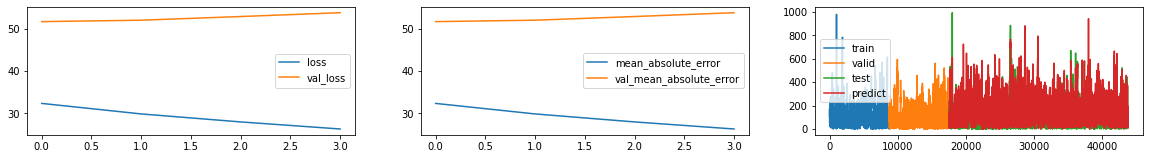

In [103]:
""" PLOT """

    
# plot history
plt.figure(figsize=(20,8))

plt.subplot(331)
plt.plot(history.history['loss'][3:], label='loss')
plt.plot(history.history['val_loss'][3:], label='val_loss')
plt.legend()

plt.subplot(332)
plt.plot(history.history['mean_absolute_error'][3:], label='mean_absolute_error')
plt.plot(history.history['val_mean_absolute_error'][3:], label='val_mean_absolute_error')
plt.legend()

plt.subplot(333)
plt.plot(range(len(train_y)), train_y, label="train")
plt.plot(range(len(train_y), len(train_y)+len(val_y)), val_y, label="valid")
plt.plot(range(len(train_y)+len(val_y), len(train_y)+len(val_y)+len(pred)), test_y, label="test")
plt.plot(range(len(train_y)+len(val_y), len(train_y)+len(val_y)+len(pred)), pred, label="predict")

plt.legend(loc='center left')
plt.show()


In [104]:
# calculate RMSE

from tensorflow.keras.metrics import RootMeanSquaredError as RMSE

rmse = RMSE(dtype='float64')
rmse_result = rmse(pred, test_y)

'Test RMSE: %.3f' % rmse_result

'Test RMSE: 70.305'

We got the RMSE on testing set as 70.305. Previously it was 57.166. Adding a new column (pollution_indicator per half day) increased the RMSE.